## 4) 随机森林

我们在第15节学过了**自举集成**（Bagging），现在再学**随机森林**简直是太简单了。

**随机森林**和**自举集成**（Bagging）： **自举集成**是对训练集样本（行数据）随机放回抽样；而**随机森林**不但要对对训练集样本（行数据）随机放回抽样，而且要对属性（列数据）随机**无放回**抽样。

也就是说， **随机森林** = **自举集成** + 属性集随机选择。

当然，既然要“属性集随机选择”， 就不能使用单属性的数据集，前面使用的玩具数据集也就不适用了。本例直接使用红酒口感的数据集。

本例我们依然使用二元决策树作为基学习器。

很自然，于是下面的代码和第15节的第二段代码也就很相似了。

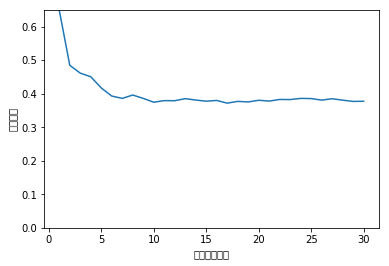

最小均方误差
0.37157098792077264


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

# 获取红酒数据集
target_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(target_url, header=0, sep=";")
df.columns = ['非挥发性酸','挥发性酸','柠檬酸', '残留糖分', '氯化物', '游离二氧化硫','总二氧化硫', '密度', 
              'PH值', '亚硝酸盐', '酒精含量', '品质']

xData = df.values[:,:-1]; yData = df.values[:,-1] 
m, n = xData.shape

'''
    采样30%的数据作为测试集
'''

mSample = int(m * 0.30);
np.random.seed(1)
idx = list(range(m));  np.random.shuffle(idx)
idxTest = idx[:mSample]; idxTest.sort()
idxTrain = list(set(idx) - set(idxTest)); idxTrain.sort()
xTrain = xData[idxTrain,:]; yTrain = yData[idxTrain]
xTest = xData[idxTest,:]; yTest = yData[idxTest]

'''
    在训练集上生成一系列模型
'''

# 生成的最大模型数
numTreesMax = 30
# 决策树深度
treeDepth = 12
# 随机选择的属性数（算法原作者推荐在回归问题中选择1/3的属性数）
nAttr = 4

# 收集模型及其对应的预测
modelList = []
indexList = []
predList = []

# 用于随机提升（bagging）的样本数 
nRfSamples = int(len(xTrain) * 0.5)
for iTrees in range(numTreesMax):
    # 列数据无放回均匀取样
    idxAttr = list(range(n));  np.random.shuffle(idxAttr)
    idxAttr = idxAttr[:nAttr]; idxAttr.sort()
    indexList.append(list(idxAttr))
    
    # 行数据有放回均匀取样
    idxRows = np.random.choice(m-mSample, nRfSamples)
    idxRows.sort()
    
    # 根据选择行列确定子模型训练集
    xRfTrain = xTrain[idxRows][:,idxAttr]
    yRfTrain = yTrain[idxRows]
    xRfTest = xTest[:,idxAttr]

    # 训练数据采样集进行二元决策树训练
    modelList.append(DecisionTreeRegressor(max_depth=treeDepth))
    modelList[-1].fit(xRfTrain, yRfTrain)

    # 预测并收集预测值
    latestPrediction = modelList[-1].predict(xRfTest)
    predList.append(list(latestPrediction))

'''
    给定头n个模型 n=1,...，numTreesMax
    依次计算n个模型的平均预测值 
    依次计算n个模型的均方误差 
'''

allPredictions = 1.0 * np.cumsum(predList,axis=0) / np.arange(1,numTreesMax+1).reshape(numTreesMax,1)
mse = ((yTest - allPredictions)**2).sum(axis=1) / len(yTest)

'''
    绘制或输出计算结果 
'''

# 绘制均方误差和模型数之间的关系
nModels = [i + 1 for i in range(numTreesMax)]
plt.plot(nModels,mse)
plt.axis('tight')
plt.xlabel(u'所用模型数目')
plt.ylabel(u'均方误差')
plt.ylim((0.0, max(mse)))
plt.show()

print(u'最小均方误差')
print(min(mse))